# Data Analysis-- Supervised Learning
* Created on Mon Sep. 29 2021 by Shangying Wang
* Last Modified: April 6, 2023
* this code is used for prediction of the phenotypes from the combinatory motifs
* This code uses the convolutional neural network and LSTM.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True)
#import pdb
from platform import python_version
print(python_version())

2023-04-06 17:31:48.368087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 17:31:49.630334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


3.10.10


In [2]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
print(tf.__version__)

2.12.0


# For arrayed data analysis

## Load data from csv file
- CSV files available at https://www.science.org/doi/suppl/10.1126/science.abq0225/suppl_file/science.abq0225_data_s1_to_s3.zip
- Change schema to match version used in original commits
- Change motif values to match those used in original commits (i.e., change 17 to 14)

In [3]:
tf.keras.utils.set_random_seed(1)
train_data=pd.read_csv('science.abq0225_data_s2.csv',encoding= 'unicode_escape',sep=',')
test_data=pd.read_csv('science.abq0225_data_s3.csv',encoding= 'unicode_escape',sep=',')
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
rename_dict = {'Initial CAR T Cell Number': 'Cell Number',
               'motif i': 'motif',
               'motif j': 'motif.1',
               'motif k': 'motif.2',
               'motif l': 'motif.3',
               'motif m': 'motif.4',
               'Cytotoxicity (Nalm 6 Survival)': 'Nalm 6 Cytotoxicity',
               'Stemness (% IL7Ra+ KLRG1-)': 'IL7RaKLRG1 stemness'}
train_data.rename(columns=rename_dict, inplace=True)
test_data.rename(columns=rename_dict, inplace=True)
train_data.drop([train_data.columns[7]], axis=1, inplace=True)
test_data.drop([test_data.columns[7]], axis=1, inplace=True)
train_data.replace(17, 14, inplace=True)
test_data.replace(17, 14, inplace=True)
test_data

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
0,4078,8,9,2,14,0,0.473548,24.10
1,2150,2,14,0,0,0,0.551460,7.34
2,2814,8,2,11,14,0,0.691060,15.10
3,7224,8,11,11,14,0,0.720755,8.96
4,3205,8,12,8,14,0,0.520676,13.40
5,3685,10,6,3,14,0,0.528674,20.30
6,2885,4,4,14,0,0,0.350036,8.98
7,1595,11,10,9,14,0,0.112309,38.80
8,1197,10,10,1,14,0,0.050364,35.60
9,2748,8,3,2,14,0,0.708795,24.00


In [4]:
#data statistics
all_data = pd.concat([test_data, train_data])
max_cell=max(all_data['Cell Number'])
all_data['Cell Number']=all_data['Cell Number']/max_cell
train_data['Cell Number']=train_data['Cell Number']/max_cell
test_data['Cell Number']=test_data['Cell Number']/max_cell
stats_df = all_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.255184,7.252033,6.926829,7.300813,12.475610,0.739837,0.615778,18.636626
std,0.210155,3.910412,3.815480,3.995783,4.147954,3.138536,0.253641,8.121087
min,0.003385,1.000000,1.000000,0.000000,0.000000,0.000000,0.002313,4.490000
25%,0.103734,3.000000,3.000000,3.000000,14.000000,0.000000,0.431323,12.500000
50%,0.194125,8.000000,8.000000,8.000000,14.000000,0.000000,0.655914,16.750000
75%,0.324693,11.000000,10.000000,11.000000,14.000000,0.000000,0.820133,23.050000
max,1.000000,13.000000,14.000000,14.000000,14.000000,14.000000,1.197448,46.200000


In [5]:
skew_vals1=all_data['Nalm 6 Cytotoxicity'].skew()
skew_vals1

-0.24443600883940617

In [6]:
skew_vals2=all_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.9456903661932705

Text(0.5, 1.0, 'after np.log1p')

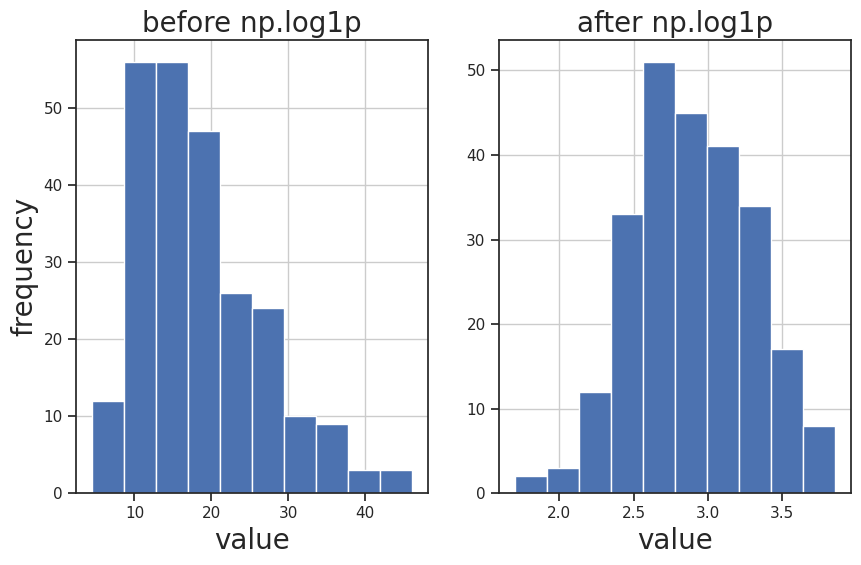

In [7]:
plt.figure(figsize=[10,20])
pheno=['IL7RaKLRG1 stemness']
new_data = all_data.copy()
pp=0
plt.subplot(3,2,1)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('before np.log1p', fontsize=20)

plt.subplot(3,2,2)
new_data[pheno[pp]]=new_data[pheno[pp]].apply(np.log1p)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
#plt.ylabel('frequency', fontsize=20)
plt.title('after np.log1p', fontsize=20)

In [8]:
skew_vals2=new_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.03784244019300669

In [9]:
train_data['IL7RaKLRG1 stemness'] = train_data['IL7RaKLRG1 stemness'].apply(np.log1p)
test_data['IL7RaKLRG1 stemness'] = test_data['IL7RaKLRG1 stemness'].apply(np.log1p)

In [10]:
stats_df = train_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,221.000000,221.00000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.257121,7.20362,6.791855,7.371041,12.656109,0.760181,0.628467,2.894458
std,0.211839,3.94959,3.800972,3.905459,3.898639,3.179687,0.252597,0.397382
min,0.003385,1.00000,1.000000,0.000000,0.000000,0.000000,0.004702,1.702928
25%,0.098971,3.00000,3.000000,3.000000,14.000000,0.000000,0.439604,2.602690
50%,0.209824,8.00000,8.000000,8.000000,14.000000,0.000000,0.666384,2.862201
75%,0.341985,11.00000,10.000000,11.000000,14.000000,0.000000,0.831310,3.173878
max,1.000000,13.00000,14.000000,14.000000,14.000000,14.000000,1.197448,3.854394


## Deep Neural Network for Nalm 6 Cytotoxicity

In [11]:
num_motifs=5
num_class=num_class=len(np.unique(new_data.iloc[:,1:(num_motifs+1)]))
np.unique(new_data.iloc[:,1:(num_motifs+1)])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [12]:
max_y=np.max(new_data['Nalm 6 Cytotoxicity'])
max_y

1.197447799

In [13]:
ICN_train, X_train, Y_train = train_data.iloc[:, :1], train_data.iloc[:,1:(num_motifs+1)], train_data['Nalm 6 Cytotoxicity']/max_y
ICN_test, X_test, Y_test = test_data.iloc[:, :1], test_data.iloc[:,1:(num_motifs+1)], test_data['Nalm 6 Cytotoxicity']/max_y

### One-hot encoding for 14 linear motifs: 

In [14]:
X_train_channel=to_categorical(X_train, num_classes=num_class)
X_test_channel=to_categorical(X_test, num_classes=num_class)
print(np.shape(X_test_channel)) #3D tensor with shape (batch_size, steps, features/channels)

(25, 5, 15)


In [15]:
output_dim = 1
batch_size = 10

In [16]:
stats_df = Y_train.describe()
stats_df

count    221.000000
mean       0.524839
std        0.210947
min        0.003927
25%        0.367118
50%        0.556504
75%        0.694235
max        1.000000
Name: Nalm 6 Cytotoxicity, dtype: float64

### CNN+LSTM 

In [ ]:
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
input_position=Input(shape=(num_motifs, num_class), name='input_position')
input_ICN=Input(shape=(1), name='input_ICN')
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)#kernel_initializer=initializer, 
x=Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
#x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
#x = Dropout(0.5)(x)
#x = Dense(8*output_dim,activation='relu')(x)
model1 = keras.Model(inputs=input_position, outputs=x)


# combine the output of the two branches
combined = concatenate([model1.output, input_ICN])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(50*output_dim, activation='relu')(combined)
#z = Dense(16*output_dim, activation='relu')(z)
z = Dropout(0.5)(z)
#z = Dense(4*output_dim, activation='relu')(z)
z = Dense(output_dim, activation='relu')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[input_position, input_ICN], outputs=z)
model.summary()

In [ ]:
# Compile the model
model.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanAbsoluteError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit([X_train_channel, ICN_train], Y_train,  batch_size=batch_size, epochs=1200, verbose=1)
#validation_data=([X_test_channel, ICN_test], Y_test), 

In [ ]:
train_scores = model.evaluate([X_train_channel,ICN_train], Y_train, verbose=0)
test_scores = model.evaluate([X_test_channel,ICN_test], Y_test, verbose=0)
print("MSE:", train_scores[1])
print("MSE:", test_scores[1])

In [ ]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [ ]:
pred_train=model.predict([X_train_channel,ICN_train])*max_y
pred_test=model.predict([X_test_channel,ICN_test])*max_y
# pred_train=np.dot(pred_train_sc, np.diag(max_y))
# pred_test=np.dot(pred_test_sc,np.diag(max_y))

In [ ]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=0
gt=Y_train*max_y
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=Y_test*max_y
plt.scatter(gt,pred_test[:,i])
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test[:,i]))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Ensemble Predistions 

In [17]:
## merge inputs
combine_input_train = np.concatenate([np.reshape(X_train_channel, [np.shape(X_train_channel)[0], -1]), ICN_train], axis=1)
combine_input_test = np.concatenate([np.reshape(X_test_channel, [np.shape(X_test_channel)[0], -1]), ICN_test], axis=1)

In [18]:
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_1.h5')
pred_test1=model.predict(combine_input_test)
pred_train1=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_2.h5')
pred_test2=model.predict(combine_input_test)
pred_train2=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_3.h5')
pred_test3=model.predict(combine_input_test)
pred_train3=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_4.h5')
pred_test4=model.predict(combine_input_test)
pred_train4=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_5.h5')
pred_test5=model.predict(combine_input_test)
pred_train5=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_6.h5')
pred_test6=model.predict(combine_input_test)
pred_train6=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_7.h5')
pred_test7=model.predict(combine_input_test)
pred_train7=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_8.h5')
pred_test8=model.predict(combine_input_test)
pred_train8=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_9.h5')
pred_test9=model.predict(combine_input_test)
pred_train9=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_Cytotoxicity_10.h5')
pred_test10=model.predict(combine_input_test)
pred_train10=model.predict(combine_input_train)
pred_test=(pred_test1+pred_test2+pred_test3+pred_test4+pred_test5+pred_test6+pred_test7+pred_test8+pred_test9+pred_test10)/10*max_y
pred_train=(pred_train1+pred_train2+pred_train3+pred_train4+pred_train5+pred_train6+pred_train7+pred_train8+pred_train9+pred_train10)/10*max_y
df = pd.DataFrame(np.around(pred_test,3), columns = ['Column_1'])
df.T

2023-04-06 17:32:28.052094: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-06 17:32:28.493616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:28.496436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:28.498588: I tensorflow/core/com

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:32:29.655525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:29.658385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:29.660612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:32:30.689575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:30.692098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:30.693765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:32:31.686862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:31.689900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:31.692292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:32:32.709026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:32.711659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:32.714030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:32:33.714210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:33.717058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:33.719225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:32:34.716283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:34.719018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:34.721388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s

2023-04-06 17:32:35.138248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:35.140651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:35.142262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:32:35.896991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:35.899779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:35.901902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s

2023-04-06 17:32:36.320835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:36.324449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:36.326956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:32:36.909446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:36.912359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:36.914837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s

2023-04-06 17:32:37.321369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:37.324844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:37.327481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:32:37.943050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:37.945435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:37.948065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 467ms/step


2023-04-06 17:32:38.369351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:32:38.372136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:32:38.374282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Column_1,0.393,0.38,0.531,0.467,0.518,0.528,0.277,0.138,0.246,0.535,...,0.321,0.424,0.424,0.464,0.376,0.603,0.531,0.276,0.53,0.457


(-0.03802068355, 0.8493271745500001, -0.03802068355, 0.8493271745500001)

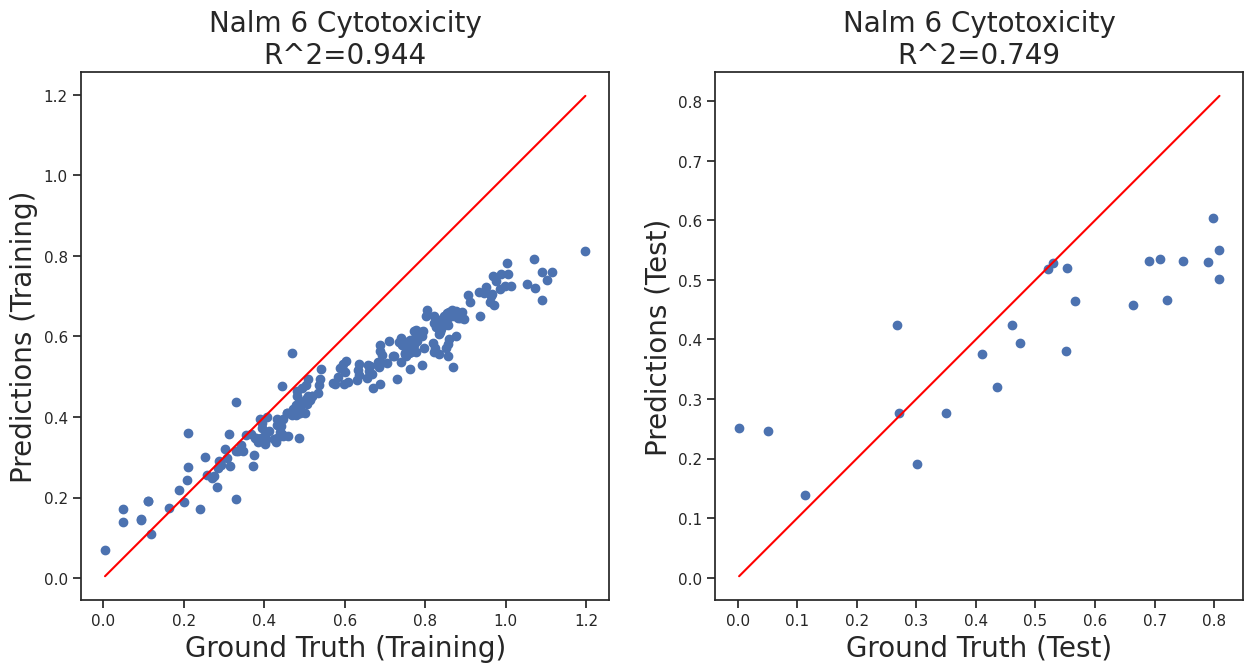

In [19]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=0
gt=Y_train*max_y
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=Y_test*max_y
plt.scatter(gt,pred_test[:,i])
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test[:,i]))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Deep Neural Network for IL7RaKLRG1 stemness

In [20]:
max_y=np.max(new_data['IL7RaKLRG1 stemness'])
max_y

3.85439389259151

In [21]:
Y_train = train_data['IL7RaKLRG1 stemness']/max_y
Y_test = test_data['IL7RaKLRG1 stemness']/max_y

In [ ]:
#define two sets of inputs
#64, 4, 0.1, 64,0.5,4
input_position=Input(shape=(num_motifs, num_class), name='input_position')
input_ICN=Input(shape=(1), name='input_ICN')
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)#kernel_initializer=initializer, 
x=Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
#x=Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
x=LSTM(4,return_sequences=True, dropout=0.3)(x)#return_sequences=True,
x = Flatten()(x)
#x = Dropout(0.5)(x)
#x = Dense(8*output_dim,activation='relu')(x)
model1 = keras.Model(inputs=input_position, outputs=x)


# combine the output of the two branches
combined = concatenate([model1.output, input_ICN])
# apply a FC layer and then a regression prediction on the
# combined outputs

z = Dense(50*output_dim, activation='relu')(combined)
#z = Dense(16*output_dim, activation='relu')(z)
z = Dropout(0.5)(z)
#z = Dense(4*output_dim, activation='relu')(z)
z = Dense(output_dim, activation='relu')(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = keras.Model(inputs=[input_position, input_ICN], outputs=z)
model.summary()

In [ ]:
# Compile the model
model.compile(
    #loss=keras.losses.MeanSquaredLogarithmicError(),
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    #optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3),
    #optimizer=Adam(lr=0.0001), #Adam optimizer
    #optimizer=SGD(lr=0.001, momentum=0.99),
    metrics=[tf.keras.metrics.MeanSquaredError()])

history = model.fit([X_train_channel, ICN_train], Y_train, batch_size=batch_size, epochs=1200, verbose=1)
#validation_data=([X_test_channel, ICN_test], Y_test), 

In [ ]:
train_scores = model.evaluate([X_train_channel,ICN_train], Y_train, verbose=0)
test_scores = model.evaluate([X_test_channel,ICN_test], Y_test, verbose=0)
print("MSE:", train_scores[1])
print("MSE:", test_scores[1])

In [ ]:
p1=plt.plot(history.history['mean_squared_error'])
#p2=plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('No. epoch')
plt.yscale('log')
#plt.legend([p1,p2], ['training','validation'])
plt.show()

In [ ]:
# pred_train=model.predict([X_train_channel,ICN_train])
# pred_test=model.predict([X_test_channel,ICN_test])
pred_train=np.exp(model.predict([X_train_channel,ICN_train])*max_y)-1
pred_test=np.exp(model.predict([X_test_channel,ICN_test])*max_y)-1

In [ ]:
np.shape(pred_test)

In [ ]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=1
gt=np.exp(Y_train*max_y)-1
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=np.exp(Y_test*max_y)-1
plt.scatter(gt,pred_test)
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

## Ensemble Predistions 

In [22]:
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_1.h5')
pred_test1=model.predict(combine_input_test)
pred_train1=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_2.h5')
pred_test2=model.predict(combine_input_test)
pred_train2=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_3.h5')
pred_test3=model.predict(combine_input_test)
pred_train3=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_4.h5')
pred_test4=model.predict(combine_input_test)
pred_train4=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_5.h5')
pred_test5=model.predict(combine_input_test)
pred_train5=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_6.h5')
pred_test6=model.predict(combine_input_test)
pred_train6=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_7.h5')
pred_test7=model.predict(combine_input_test)
pred_train7=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_8.h5')
pred_test8=model.predict(combine_input_test)
pred_train8=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_9.h5')
pred_test9=model.predict(combine_input_test)
pred_train9=model.predict(combine_input_train)
model = keras.models.load_model('saved_model/position_encoding_arrayed_data_04062023_CNN_LSTM_stemness_10.h5')
pred_test10=model.predict(combine_input_test)
pred_train10=model.predict(combine_input_train)
pred_test=(pred_test1+pred_test2+pred_test3+pred_test4+pred_test5+pred_test6+pred_test7+pred_test8+pred_test9+pred_test10)/10*max_y
pred_train=(pred_train1+pred_train2+pred_train3+pred_train4+pred_train5+pred_train6+pred_train7+pred_train8+pred_train9+pred_train10)/10*max_y
df = pd.DataFrame(np.around(pred_test,3), columns = ['Column_1'])
df.T

2023-04-06 17:33:45.097175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:45.101584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:45.104949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:33:46.211678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:46.214932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:46.217353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:33:47.243876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:47.246838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:47.248888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:33:48.217144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:48.220036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:48.222764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:33:49.196989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:49.200082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:49.203088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:33:50.244999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:50.248146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:50.251361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 2ms/step


2023-04-06 17:33:51.287262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:51.290343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:51.292705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:33:52.371499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:52.375214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:52.377989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:33:53.507848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:53.510828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:53.513640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


2023-04-06 17:33:54.834181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-06 17:33:54.837627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-06 17:33:54.840466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 0s 3ms/step


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Column_1,2.988,2.504,2.739,2.966,2.736,2.888,2.515,3.35,3.4,2.786,...,2.792,3.031,2.903,2.758,2.795,2.779,2.779,2.79,3.128,2.587


(5.767000000000002, 40.37299999999999, 5.767000000000002, 40.37299999999999)

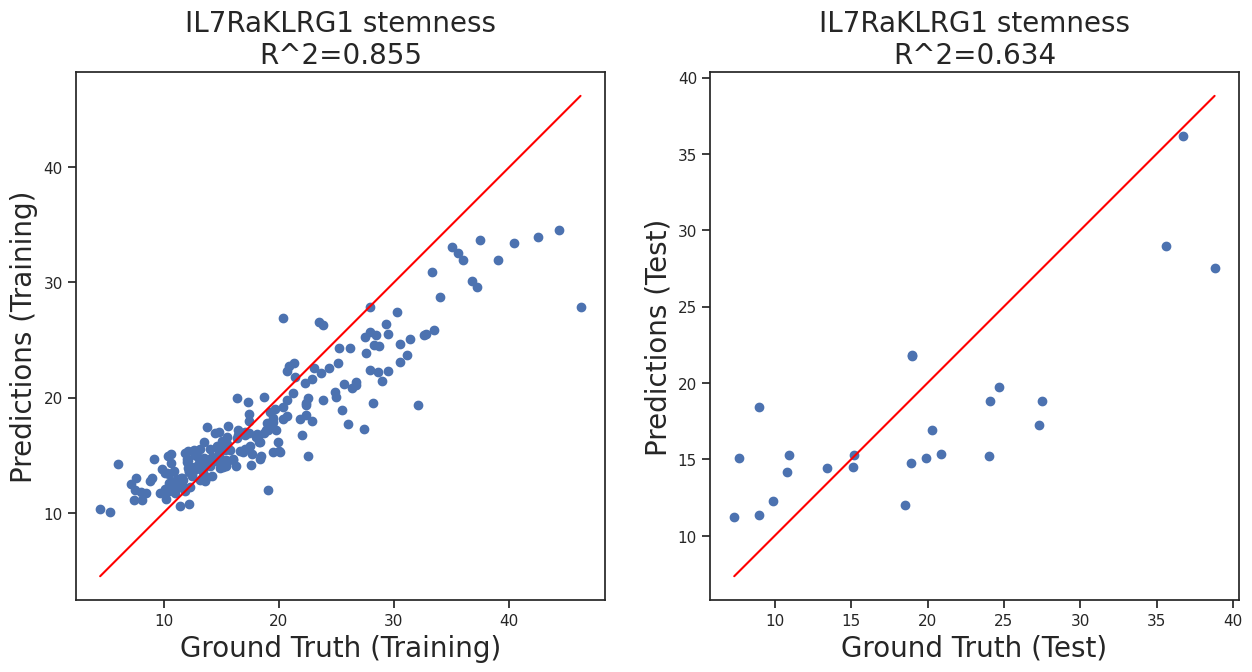

In [23]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=1
gt=np.exp(Y_train*max_y)-1
pred_train=np.exp(pred_train)-1
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=np.exp(Y_test*max_y)-1
pred_test=np.exp(pred_test)-1
plt.scatter(gt,pred_test)
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test[:,0])
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')